# Address classification (combine fuzzy with digram)

In [1]:
import json
import random
import re
import time
import signal
import matplotlib.pyplot as plt

## Import adminstrative region data

In [2]:
with open("./Data/region_tree.json", 'r') as file:
    region_tree = json.load(file)
    
with open("./Data/reverse_index_dist_to_prov.json", 'r') as file:
    rev_index_dist_to_prov = json.load(file)
    
with open("./Data/reverse_index_ward_to_prov.json", 'r') as file:
    rev_index_ward_to_prov = json.load(file)
    
with open("./Data/reverse_index_ward_to_dist.json", 'r') as file:
    rev_index_ward_to_dist = json.load(file)

In [3]:
all_provinces = [province['name'] for province in region_tree.values()]
all_districts = [district['name'] for district in rev_index_dist_to_prov.values()]
all_wards = [ward['name'] for ward in rev_index_ward_to_prov.values()]

## Read test case

In [4]:
with open("./AddressTestcase/public.json") as file:
    testcases = json.load(file)

In [5]:
tests = [testcase['text'] for testcase in testcases]
ground_truths = [testcase['result'] for testcase in testcases]

## Filter out bad test cases

In [6]:
def check_province_exist(prov:str) -> bool:
    return (prov in region_tree)
    
def check_district_exist(dist: str) -> bool:
    return (dist in rev_index_dist_to_prov)

def check_ward_exist(ward: str) -> bool:
    return (ward in rev_index_ward_to_prov)

def check_correct_hierarchy_ward_to_district(ward: str, dist: str) -> bool:
    # assume ward and dist exist
    dist_have_ward_list = rev_index_ward_to_dist[ward]['districts']
    return (dist in dist_have_ward_list)

def check_correct_hierarchy_ward_to_province(ward: str, prov: str) -> bool:
    # assume ward and prov exist
    prov_have_ward_list = rev_index_ward_to_prov[ward]['provinces']
    return (prov in prov_have_ward_list)

def check_correct_hierarchy_district_to_province(dist: str, prov: str) -> bool:
    # assume dist and prov exist
    prov_have_dist_list = rev_index_dist_to_prov[dist]['provinces']
    return (prov in prov_have_dist_list)

def result_is_consistent_with_regional_data(province: str, district: str, ward: str) -> bool:
    have_prov = (len(province) > 0)
    have_dist = (len(district) > 0)
    have_ward = (len(ward) > 0)
    
    if have_prov and not check_province_exist(province):
        return False 
    if have_dist and not check_district_exist(district):
        return False
    if have_ward and not check_ward_exist(ward):
        return False
    
    if have_ward and have_dist:
        if not check_correct_hierarchy_ward_to_district(ward, district):
            return False
    if have_ward and have_prov:
        if not check_correct_hierarchy_ward_to_province(ward, province):
            return False
    if have_dist and have_prov:
        if not check_correct_hierarchy_district_to_province(district, province):
            return False
        
    return True

def have_no_data(province: str, district: str, ward: str) -> bool:
    have_prov = (len(province) > 0)
    have_dist = (len(district) > 0)
    have_ward = (len(ward) > 0)
    
    return (not have_prov and not have_dist and not have_ward)

In [7]:
good_ground_truths = [result_is_consistent_with_regional_data(**gt) and not have_no_data(**gt) 
                      for gt in ground_truths]
tests = [test for i, test in enumerate(tests) if good_ground_truths[i]]
ground_truths = [gt for i, gt in enumerate(ground_truths) if good_ground_truths[i]]

## Levenshtein distance + Fuzzy matching

In [8]:
def levenshtein_dist(s1: str, s2: str) -> int:
    len_s1 = len(s1)
    len_s2 = len(s2)
    
    d = [[0]*(len_s2+1) for _ in range(len_s1+1)]
    
    for i in range(1, len_s1+1):
        d[i][0] = i
        
    for j in range(1, len_s2+1):
        d[0][j] = j
    
    for j in range(1, len_s2+1):
        for i in range(1, len_s1+1):
            if s1[i-1] == s2[j-1]:
                substitutionCost = 0
            else:
                substitutionCost = 1

            d[i][j] = min(d[i-1][j] + 1,
                          d[i][j-1] + 1,
                          d[i-1][j-1] + substitutionCost) 

    return d[-1][-1]

def approx_substring_matching_backtrace(e, f, best_match_pos: (int, int)) -> (int, int):
    i, j = best_match_pos
    while i != 0:
        #print(i, j)
        if f[i][j] == 0:
            i, j = i-1, j
        elif f[i][j] == 1:
            i, j = i, j-1
        elif f[i][j] == 2:
            i, j = i-1, j-1
        else:
            raise
    return (j, best_match_pos[1])

def approx_substring_matching(pattern: str, text: str, favor_end_match=False) -> (int, (int, int)):
    len_p = len(pattern)
    len_t = len(text)
    
    e = [[0]*(len_t+1) for _ in range(len_p+1)]
    f = [[0]*(len_t+1) for _ in range(len_p+1)]

    for i in range(1, len_p+1):
        e[i][0] = i
        
    for j in range(1, len_t+1):
        f[0][j] = 1
    
    for j in range(1, len_t+1):
        for i in range(1, len_p+1):
            cost = [ e[i-1][j] + 1,
                     e[i][j-1] + 1,
                     e[i-1][j-1] + (pattern[i-1] != text[j-1]) ]
            
            f[i][j] = cost.index(min(cost))
            e[i][j] = min(cost)
    
    min_dist = min(e[len_p])
    if favor_end_match:
        min_substr_end = min(range(len(e[len_p])), key=lambda i: e[len_p][i]-i)
    else:
        min_substr_end = e[len_p].index(min_dist)
    min_substr_end = min_substr_end - 1 if min_substr_end > 0 else min_substr_end
        
    return (min_dist, approx_substring_matching_backtrace(e, f, (len_p, min_substr_end)))

## Build dictionary mapping digram to region name

In [9]:
def digram_from_string(string: str) -> [str]: # return list of digram
    string = string.strip().lower()
    if len(string) == 1:
        return [string + ' ']
    
    normal_digram = [string[i]+string[i+1] for i in range(len(string)-1)]
    head_tail_digram = string[0] + string[-1]
    #one_gap_digram = [string[i]+string[i+2] for i in range(len(string)-2)]
    one_over_last_digram = string[-1] + ' '
    one_before_first_digram = ' ' + string[0]
    
    return [head_tail_digram, 
            *normal_digram, 
            #*one_gap_digram, 
            one_over_last_digram, 
            one_before_first_digram
           ]

In [10]:
digram_to_region = {}
digram_count = 0
dupli_count = 0

for region_name in all_provinces:
    digrams = []
    for w in region_name.split():
        digrams += digram_from_string(w)
    
    for dg in digrams:
        digram_count += 1
        dupli_count += dg in digram_to_region
        if dg in digram_to_region:
            digram_to_region[dg]['province'].add(region_name)
        else:
            digram_to_region[dg] = {
                'province': set([region_name]),
                'district': set(),
                'ward': set()
            }
            
for region_name in all_districts:
    digrams = []
    for w in region_name.split():
        digrams += digram_from_string(w)
    
    for dg in digrams:
        digram_count += 1
        dupli_count += dg in digram_to_region
        if dg in digram_to_region:
            digram_to_region[dg]['district'].add(region_name)
        else:
            digram_to_region[dg] = {
                'province': set(),
                'district': set([region_name]),
                'ward': set()
            }

for region_name in all_wards:
    digrams = []
    for w in region_name.split():
        digrams += digram_from_string(w)
    
    for dg in digrams:
        digram_count += 1
        dupli_count += dg in digram_to_region
        if dg in digram_to_region:
            digram_to_region[dg]['ward'].add(region_name)
        else:
            digram_to_region[dg] = {
                'province': set(),
                'district': set(),
                'ward': set([region_name])
            }

## Find region with digram

In [11]:
def find_region_with_digram(addr):
    words = addr.strip().split()
    prov_candidate = dist_candidate = ward_candidate = None
    
    for word in words:
        digrams = digram_from_string(word)
        possible_prov = possible_dist = possible_ward = set()
        
        for dg in digrams:
            possible_prov = possible_prov | (digram_to_region[dg]['province'] if dg in digram_to_region else set())
            possible_dist = possible_dist | (digram_to_region[dg]['district'] if dg in digram_to_region else set())
            possible_ward = possible_ward | (digram_to_region[dg]['ward'] if dg in digram_to_region else set())

        if prov_candidate is None:
            prov_candidate = possible_prov
        else:
            prov_candidate = prov_candidate & possible_prov
            
        if dist_candidate is None:
            dist_candidate = possible_dist
        else:
            dist_candidate = dist_candidate & possible_dist
            
        if ward_candidate is None:
            ward_candidate = possible_ward
        else:
            ward_candidate = ward_candidate & possible_ward

        #print('prov: {}\ndist: {}\nward: {}'.format(possible_prov, possible_dist, possible_ward))
        #print('-' * 5)

    #print('prov: {}\ndist: {}\nward: {}'.format(prov_candidate, dist_candidate, ward_candidate))
    #print('-' * 5)
        
    return {
        'province': prov_candidate, 
        'district': dist_candidate, 
        'ward': ward_candidate
    }

In [12]:
def get_list_of_region_with_constraints_recursive(result, province: {}, district: {}, ward: {}, 
                                                  level:int, stop_level:int = 0) -> None:
    # province, district and ward can be None
    if level <= stop_level:
        return
    if not (1 <= level <= 3):
        return
    
    if level == 3:
        region_level = 'province'
        if province is not None:
            result[region_level] = {province['name']: province}
        else:
            result[region_level] = region_tree
        get_list_of_region_with_constraints_recursive(result, province, district, ward, 2)

    elif level == 2:
        region_level = 'district'
        if district is not None:
            result[region_level] = {district['name']: district}
            
            new_prov_list = {}
            for prov_name, prov_info in result['province'].items():
                if district in prov_info['districts'].values():
                    new_prov_list[prov_name] = prov_info
            result['province'] = new_prov_list
        else:
            dist_list = {}
            for prov in result['province'].values():
                for dist in prov['districts'].values():
                    dist_list[(prov['name'], dist['name'])] = dist
            result[region_level] = dist_list
        get_list_of_region_with_constraints_recursive(result, province, district, ward, 1)
            
    elif level == 1:
        region_level = 'ward'
        if ward is not None:
            result[region_level] = {ward['name']: ward}
            
            new_dist_list = {}
            for dist_name, dist_info in result['district'].items():
                if ward in dist_info['wards'].values():
                    new_dist_list[dist_name] = dist_info
            result['district'] = new_dist_list
        else:
            ward_list = {}
            for dist in result['district'].values():
                for w in dist['wards'].values():
                    ward_list[(dist['name'], w['name'])] = w
            result[region_level] = ward_list
        get_list_of_region_with_constraints_recursive(result, province, district, ward, 0)


def get_list_of_region_with_constraints(province: {}, district: {}, ward: {}, stop_level:int = 0):
    # province, district and ward can be None
    result = {
        'province': None, 
        'district': None, 
        'ward': None
    }
    get_list_of_region_with_constraints_recursive(result, province, district, ward, level=3, stop_level=stop_level)
    
    result['province']  = {prov['name'] for prov in result['province'].values()}
    result['district']  = {dist['name'] for dist in result['district'].values()}
    result['ward']  = {ward['name'] for ward in result['ward'].values()}
    
    return result

In [13]:
def find_region_with_digram_with_constraints(string: str, level:int, province: {}, district: {}, ward: {}):
    # province, district and ward can be None
    from_digram = find_region_with_digram(string)
    from_constraint = get_list_of_region_with_constraints(province, district, ward)
    
    prov_result = (from_digram['province'] & from_constraint['province']) if level == 3 else from_constraint['province']
    dist_result = (from_digram['district'] & from_constraint['district']) if level == 2 else from_constraint['district']
    ward_result = (from_digram['ward'] & from_constraint['ward']) if level == 1 else from_constraint['ward']
    
    return {
        'province': prov_result, 
        'district': dist_result, 
        'ward': ward_result
    }

In [14]:
def get_region_info_list_from_possibilities_with_constraints(
    possibilities: {}, level: int, province: {}, district: {}, ward: {}):
    # designed to be used by find_region_with_digram_within_region
    
    last_level_region_list = {}
    current_level_region_list = {}
    current_level = 3
    
    while True:
        last_level_region_list = current_level_region_list
        current_level_region_list = {}
        
        if current_level == 3:
            if province is not None:
                current_level_region_list[province['name']] = province
            else:
                current_level_region_list = {region_tree[prov]['name']: region_tree[prov] 
                                             for prov in possibilities['province']}
                
                # filter out prov that exists within possibility
                filtered_list = {}
                for pos_prov in possibilities['province']:
                    if pos_prov in current_level_region_list:
                        filtered_list[pos_prov] = current_level_region_list[pos_prov]
                
                #print('filtered dist: ', [r['name'] for r in filtered_list.values()])
                current_level_region_list = filtered_list
                
        elif current_level == 2:
            if district is not None:
                current_level_region_list[district['name']] = district 
            else:
                # get list of all dist with current set of prov
                for prov_name, prov_info in last_level_region_list.items():
                    for dist_name, dist_info in prov_info['districts'].items():
                        current_level_region_list[(prov_name, dist_name)] = dist_info
                
                # filter out dist that exists within possibility
                filtered_list = {}
                for pos_dist in possibilities['district']:
                    for dist_name, dist_info in current_level_region_list.items():
                        if pos_dist == dist_name[-1]:
                            filtered_list[pos_dist] = dist_info
                
                #print('filtered dist: ', [r['name'] for r in filtered_list.values()])
                current_level_region_list = filtered_list
            
        elif current_level == 1:
            if ward is not None:
                current_level_region_list[ward['name']] = ward
            else:
                # get list of all ward with current set of dist
                for dist_name, dist_info in last_level_region_list.items():
                    for ward_name, ward_info in dist_info['wards'].items():
                        current_level_region_list[(dist_name, ward_name)] = ward_info
                
                # filter out dist that exists within possibility
                filtered_list = {}
                for pos_ward in possibilities['ward']:
                    for ward_name, ward_info in current_level_region_list.items():
                        if pos_ward == ward_name[-1]:
                            filtered_list[pos_ward] = ward_info
                
                #print('filtered ward: ', [r['name'] for r in filtered_list.values()])
                current_level_region_list = filtered_list
                
        else:
            raise
        
        if current_level == level:
            break
        current_level -= 1
        
    return current_level_region_list

## Extract important part heuristic

In [15]:
def clean_and_extract_important_part(addr:str, word_count=10) -> str:
    # either take 3 delimited segment from the end of addr 
    # or as much as possible such that total number of word taken is not more than 10
    # also remove all dot (.)
    _WORD_LIMIT = word_count
    
    addr = addr.replace('TP', 'TP ')
    #addr = re.compile(r'([a-z])([A-Z])').sub(r'\1 \2', addr)
    addr = addr.replace('.', '')
    addr = addr.replace('-', '')
    
    segs = addr.split(',')
    for i, seg in enumerate(segs):
        segs[i] = ' '.join(seg.strip().split()) # remove unneeded space
    #segs = [seg for seg in segs if seg] # remove empty seg
    
    if len(segs) < 2:
        return [' '.join(addr.split()[-_WORD_LIMIT:])]
    
    word_count = 0
    num_seg_taken = 0
    seg_taken = []
    
    for i in range(len(segs)):
        curr_seg = segs[-(i+1)]
        seg_word_count = len(curr_seg.split())
        #if seg_word_count == 0 and not curr_seg.isalnum():
            #continue

        if seg_word_count + word_count > _WORD_LIMIT:
            break

        seg_taken.append(curr_seg)
        word_count = word_count + seg_word_count
        
        if len(seg_taken) >= 3:
            break
    
    if len(seg_taken) == 3:
        return seg_taken
    elif len(seg_taken) == len(segs):
        return seg_taken
    else:
        num_seg_taken = len(seg_taken)
        word_left = _WORD_LIMIT - word_count
        word_from_last_seg = segs[-(num_seg_taken+1)].split()[-word_left:]
        word_from_last_seg = ' '.join(word_from_last_seg)
        return [*seg_taken, word_from_last_seg]

In [16]:
print(
    clean_and_extract_important_part('Số 1410 Đường 30/4, Phường 12, Thành phố Vũng Tàu, Bà Rịa - Vũng Tàu.'),
    clean_and_extract_important_part('820/12 Hậu Giang, Phường 12 Quận 6, TP. Hồ Chí Minh'),
    clean_and_extract_important_part('Thôn Lùng Bẻ Kim Linh, Vị Xuyên, Hà Giang'),
    clean_and_extract_important_part('TT Tân Bình Huyện Yên Sơn, Tuyên Quang'),
    clean_and_extract_important_part('59/12 Ng-B-Khiêm, Đa Kao Quận 1,, TP. Hồ Chí Minh'),
    clean_and_extract_important_part('Đức Lĩnh,Vũ Quang,'),
    clean_and_extract_important_part('Thới Hòa A Thị trấn Cờ Đỏ, Cờ Đỏ, Cần Thơ'),
    clean_and_extract_important_part('test1, test2, '),
    clean_and_extract_important_part('a b c d e f g h i j test1,, test2'),
    sep='\n'
)

['Bà Rịa Vũng Tàu', 'Thành phố Vũng Tàu', 'Phường 12']
['TP Hồ Chí Minh', 'Phường 12 Quận 6', 'Hậu Giang']
['Hà Giang', 'Vị Xuyên', 'Thôn Lùng Bẻ Kim Linh']
['Tuyên Quang', 'TT Tân Bình Huyện Yên Sơn']
['TP Hồ Chí Minh', '', 'Đa Kao Quận 1']
['', 'Vũ Quang', 'Đức Lĩnh']
['Cần Thơ', 'Cờ Đỏ', 'Hòa A Thị trấn Cờ Đỏ']
['', 'test2', 'test1']
['test2', '', 'c d e f g h i j test1']


## Abbreviation

In [17]:
def get_abbre_with_word_first_letter(string: str, *, with_sep=False, sep='.') -> str:
    
    words = string.strip().split()
    if len(words) < 2:
        return string[0].upper()
    
    for i, word in enumerate(words):
        words[i] = word.capitalize()
    
    sep = sep if with_sep else ''
    result = ''
    
    for word in words:
        if not word.isalnum():
            result += word[0]
        else:
            result += word[0] + (sep if with_sep else '')
    
    return result

In [18]:
def get_abbre_with_word_first_letter_incomplete_last_word(string: str, *, 
                                                          with_sep=False, sep='.',
                                                          with_space_for_last_word=False) -> str:
    words = string.strip().split()
    if len(words) < 2:
        return string[0].upper()
    
    for i, word in enumerate(words):
        words[i] = word.capitalize()
    
    sep = sep if with_sep else ''
    result = ''
    
    for word in words[:-1]:
        if not word.isalnum():
            result += word[0]
        else:
            result += word[0] + (sep if with_sep else '')
    
    result += (' ' if with_space_for_last_word else '') + words[-1]
    
    return result

In [19]:
def get_abbre(string: str) -> str:
    r1 = get_abbre_with_word_first_letter(string, with_sep=False)
    r2 = get_abbre_with_word_first_letter(string, with_sep=True, sep='.')
    r3 = get_abbre_with_word_first_letter(string, with_sep=True, sep=' ')
    
    r4 = get_abbre_with_word_first_letter_incomplete_last_word(string, with_sep=False)
    r5 = get_abbre_with_word_first_letter_incomplete_last_word(string, with_sep=True, sep='.')
    r6 = get_abbre_with_word_first_letter_incomplete_last_word(string, with_sep=True, sep=' ')

    return r1, r2, r3, r4, r5, r6

## Remove region prefix

In [20]:
def split_last_n_words(string: str, n: int) -> str:
    words = string.split()
    return ' '.join(words[:-n]), ' '.join(words[-n:])

def remove_appro_wrong_region_prefix(string: str, level: int) -> str:
    ward_prefixes = ['Phường', 'Thị trấn', 'Xã']
    dist_prefixes = ['Quận', 'Huyện', 'Thành phố', 'Thị xã']
    prov_prefixes = ['Tỉnh', 'Thành phố']
    
    if level == 3:
        prefixes = prov_prefixes
    elif level == 2:
        prefixes = dist_prefixes
    elif level == 1: 
        prefixes = ward_prefixes
    else:
        raise
    
    for p in prefixes:
        front, back = split_last_n_words(string, len(p.split()))
        match_result = (*approx_substring_matching(p.lower(), back.lower()), p)
        
        if match_result[0] / len(match_result[2]) < 0.3:
            #print('---', back, match_result, match_result[0] / len(match_result[2]))
            rm_from, rm_to = match_result[1]
            back = back[:rm_from] + back[rm_to+1:]
            return front + ' ' + back
            
    return string

def remove_region_prefix(string: str, prefix: str, hint_before: int, level: int) -> str:
    re_list = [re.compile(prefix, re.IGNORECASE)]
    for a in get_abbre(prefix):
        re_list.append(re.compile(a, re.IGNORECASE))
    
    for regex in re_list:
        p_len = len(regex.pattern)
        hint_start = hint_before-1-p_len if hint_before-1-p_len >= 0 else 0
        hint_zone = (hint_start, hint_before)
        hint_string = string[hint_zone[0]:hint_zone[1]]
        
        #print('hint_zone', hint_zone)
        
        result, count = regex.subn('', hint_string, count=1)
        if count == 1:
            return (string[:hint_zone[0]] + result + string[hint_zone[1]:]).strip()
        
    # if region prefix not found, try wrong one
    string = remove_appro_wrong_region_prefix(string, level)
    return string

## Implement address classification

In [21]:
def find_best_match_region(addr: str, region_list) -> (int, (int, int), {}):
    # find best match province
    region_name_list = [r for r in region_list.keys()]
    
    scores = []
    for region in region_name_list:
        
        # check abbreviation before checking fuzzy
        abbrs = get_abbre(region)
        for abbr in abbrs:
            abbr_with_bound = r'\b' + abbr.strip() + r'\b'
            match = re.search(abbr_with_bound, addr)
            if match and match.span()[1] >= len(addr)-4:
                scores.append((0, match.span(), region_list[region]))
        
        # check fuzzy
        score = (*approx_substring_matching(region.lower(), addr.lower()), region_list[region])
        scores.append(score)
    
    best_match = min(scores, key=lambda score : (score[0], -score[1][1], -(score[1][1]-score[1][0]+1)))
        
    return best_match

def clean_up_after_region_match_found(addr: str, match_result: (int, (int, int), {}), level: int) -> str:
    rm_from, rm_to = match_result[1]
    region_prefix = match_result[2]['prefix']
    
    addr = addr[:rm_from] + addr[rm_to+1:]
    addr = remove_region_prefix(addr, region_prefix, hint_before=rm_from, level=level)
    
    return addr.strip()

In [38]:
def get_last_n_word_or_1_number(string: str, n: int) -> str:
    words = string.split()
    last_n_words = words[-n:]
    
    if last_n_words[-1].isnumeric():
        return last_n_words[-1]
    else:
        return ' '.join(last_n_words)
    

def find_next_level_region(string: str, past_result: {}, current_level: int, /, 
                           debug=False, reject_thres=4) -> (str, bool):
    if current_level == 3:
        # find best match province
        best_match_prov = find_best_match_region(string, region_tree)
        if debug:
            print(best_match_prov[0], best_match_prov[1], best_match_prov[2]['name'])
            
        if best_match_prov[0] < reject_thres:
            past_result['province'] = best_match_prov[2]
        else:
            return string, False
        
        string = clean_up_after_region_match_found(string, best_match_prov, current_level)
        
    elif current_level == 2:
        if past_result['province'] is None:
            region_suggs = find_region_with_digram_with_constraints(
                get_last_n_word_or_1_number(string, 2), 2, **past_result)
            region_suggs = get_region_info_list_from_possibilities_with_constraints(
                region_suggs, 2, **past_result)
            districts = region_suggs
            if len(districts) == 0 or len(districts) > 300:
                return string, False
        else:
            districts = past_result['province']['districts']
        
        # find best match district
        best_match_dist = find_best_match_region(string, districts)
        if debug:
            print(best_match_dist[0], best_match_dist[1], best_match_dist[2]['name'])
        
        if best_match_dist[0] < reject_thres:
            past_result['district'] = best_match_dist[2]
        else:
            return string, False
        
        string = clean_up_after_region_match_found(string, best_match_dist, current_level)
    
    elif current_level == 1:
        if past_result['district'] is None:
            region_suggs = find_region_with_digram_with_constraints(
                get_last_n_word_or_1_number(string, 2), 1, **past_result)
            region_suggs = get_region_info_list_from_possibilities_with_constraints(
                region_suggs, 1, **past_result)
            wards = region_suggs
            if len(wards) == 0 or len(wards) > 300:
                return string, False
        else:
            wards = past_result['district']['wards']
        
        # find best match ward
        best_match_ward = find_best_match_region(string, wards)
        if debug:
            print(best_match_ward[0], best_match_ward[1], best_match_ward[2]['name'])
            
        if best_match_ward[0] < reject_thres:
            past_result['ward'] = best_match_ward[2]
        else:
            return string, False
        
        string = clean_up_after_region_match_found(string, best_match_ward, current_level)
        
    else:
        raise
        
    return string, True

In [39]:
def no_info_left_in_part_heuristic(part: str) -> bool:
    text = ''.join(part.split()).strip()
    total_score = 0
    for c in text:
        if c.isdigit():
            total_score += 2
        else:
            total_score += 1
        
    return total_score <= 3

In [40]:
def address_classification(addr: str, debug=False, reject_thres=4) -> {
    'province': str,
    'district': str,
    'ward': str
}:
    parts = clean_and_extract_important_part(addr)
    current_level = 3
    result = {'province': None, 'district': None, 'ward': None}

    if debug:
        print(parts)
    
    for part in parts:
        if part == '':
            current_level -= 1
        while part: # part is not empty string
                
            if debug:
                print('part:', part)
                print('level:', current_level)
                
            part, found = find_next_level_region(part, result, current_level, debug=debug, reject_thres=reject_thres)
            
            if not found: # either missing a level, or no info left in part
                if (debug):
                    print('not found...')
                    
                if no_info_left_in_part_heuristic(part): # no info left, skip to next part
                    if debug:
                        print('no info left')
                    break
                else: # missing a level
                    current_level -= 1
            else:
                current_level -= 1
                if no_info_left_in_part_heuristic(part): # no info left, skip to next part
                    if debug:
                        print('no info left')
                    break
            
            if debug:
                print('part after:', part)
                print('level after:', current_level)
                print('result:',
                      result['province']['name'] if result['province'] is not None else None, 
                      result['district']['name'] if result['district'] is not None else None, 
                      result['ward']['name'] if result['ward'] is not None else None)
                print('-' * 5)
                
            if current_level == 0:
                break
        
        if current_level == 0:
            break
    
    for k in result.keys():
        result[k] = result[k]['name'] if result[k] is not None else ''
    
    return result

In [41]:
def signal_handler(signum, frame):
    raise Exception()

signal.signal(signal.SIGALRM, signal_handler)

def address_classification_with_time_limit(addr: str, time_limit_sec, debug=False, reject_thres=4) -> {
    'province': str,
    'district': str,
    'ward': str
}:
    signal.setitimer(signal.ITIMER_REAL, time_limit_sec - 0.002) # set timer, -2ms for varibility

    try:
        result = address_classification(addr, debug, reject_thres)
        signal.setitimer(signal.ITIMER_REAL, 0) # clear timer
        return result
    except Exception:
        signal.setitimer(signal.ITIMER_REAL, 0) # clear timer
        return {
            'province': '',
            'district': '',
            'ward': ''
        }

## Try test cases

In [47]:
def compare_result(result, truth) -> bool:
    for k, v in result.items():
        if truth[k] != v:
            return False
    return True

In [48]:
correct = 0
count = 0
runtimes = []
wrong_test_indices = []
reject_threshold = 3
time_limit_sec = 0.097

for i in range(len(tests)):
    start = time.perf_counter_ns()
    result = address_classification_with_time_limit(
        tests[i], time_limit_sec=time_limit_sec, reject_thres=reject_threshold)
    runtime = time.perf_counter_ns() - start
    runtimes.append(runtime)
    
    if (compare_result(result, ground_truths[i])):
        correct += 1
    else:
        wrong_test_indices.append(i)
    count += 1
        
print(correct, count)
print(sum(runtimes)/len(runtimes) / 1_000_000, 'ms')

404 435
19.37868171724138 ms


(array([ 9., 10.,  8., 19., 29., 23., 24., 18., 25., 20., 19., 22., 23.,
        18., 27., 19., 14., 17., 18., 10.,  5.,  3.,  4.,  6.,  1.,  3.,
         1.,  1.,  1.,  3.,  2.,  3.,  2.,  2.,  1.,  2.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         1.,  1.,  0.,  0.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([ 6.386996  ,  7.27934604,  8.17169608,  9.06404612,  9.95639616,
        10.8487462 , 11.74109624, 12.63344628, 13.52579632, 14.41814636,
        15.3104964 , 16.20284644, 17.09519648, 17.98754652, 18.87989656,
        19.7722466 , 20.66459664, 21.55694668, 22.44929672, 23.34164676,
        24.2339968 , 25.12634684, 26.01869688, 26.91104692, 27.80339696,
        28.695747  , 29.58809704, 30.48044708, 31.37279712, 32.265147

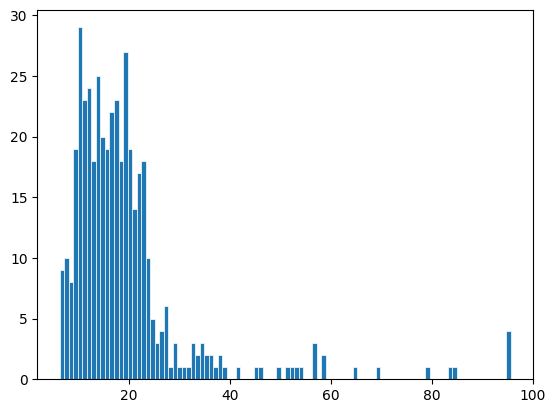

In [49]:
# plot runtimes
runtimes_ms = [rt/1_000_000 for rt in runtimes]
fig, ax = plt.subplots()
ax.hist(runtimes_ms, bins=100, linewidth=0.5, edgecolor="white")

In [29]:
for i in wrong_test_indices:
    print(tests[i])
    result = address_classification(tests[i], reject_thres=reject_threshold)
    print(result, ground_truths[i], sep='\n')
    print('-' * 5)

357/28,Ng-T- Thuật,P1,Q3,TP.HồChíMinh.
{'province': 'Hồ Chí Minh', 'district': '3', 'ward': '14'}
{'province': 'Hồ Chí Minh', 'district': '', 'ward': ''}
-----
Khu phố 4 Thị trấn, Dương Minh Châu, Tây Ninh
{'province': 'Tây Ninh', 'district': 'Dương Minh Châu', 'ward': 'Phan'}
{'province': 'Tây Ninh', 'district': 'Dương Minh Châu', 'ward': ''}
-----
A:12A.21BlockA C/c BCA,P.AnKhánh,TP.Thủ Đức, TP. HCM
{'province': 'Hồ Chí Minh', 'district': 'Thủ Đức', 'ward': 'An Khánh'}
{'province': 'Hồ Chí Minh', 'district': 'Thủ Đức', 'ward': ''}
-----
L10C12 Hẻm 90, Ng, Bỉnh Khiêm, TP. Rạch Giá, Kiên Giang
{'province': 'Kiên Giang', 'district': 'Rạch Giá', 'ward': ''}
{'province': 'Kiên Giang', 'district': '', 'ward': ''}
-----
14.5 Block A2, The Mansion, ĐS 7,KDC 13E,Ấp 5,PP,BC, TP.HCM
{'province': 'Hồ Chí Minh', 'district': 'Bình Chánh', 'ward': 'Phong Phú'}
{'province': 'Hồ Chí Minh', 'district': '', 'ward': ''}
-----
F2B PhanVănTr P.5,GV,TP.Hồ Chí Minh
{'province': 'Hồ Chí Minh', 'district': 'G

In [46]:
addr = '820/12 Hậu Giang, Phường 12 Quận 6'
address_classification(addr, debug=True, reject_thres=reject_threshold)

['Phường 12 Quận 6', '820/12 Hậu Giang']
part: Phường 12 Quận 6
level: 3
4 (13, 14) Sơn La
not found...
part after: Phường 12 Quận 6
level after: 2
result: None None None
-----
part: Phường 12 Quận 6
level: 2
0 (15, 16) 6
part after: Phường 12
level after: 1
result: None 6 None
-----
part: Phường 12
level: 1
0 (7, 8) 12
no info left


{'province': '', 'district': '6', 'ward': '12'}

In [31]:
[reg for reg in region_tree['Quảng Ninh']['districts']['Quảng Yên']['wards']]

['Quảng Yên',
 'Đông Mai',
 'Minh Thành',
 'Sông Khoai',
 'Hiệp Hòa',
 'Cộng Hòa',
 'Tiền An',
 'Hoàng Tân',
 'Tân An',
 'Yên Giang',
 'Nam Hoà',
 'Hà An',
 'Cẩm La',
 'Phong Hải',
 'Yên Hải',
 'Liên Hòa',
 'Phong Cốc',
 'Liên Vị',
 'Tiền Phong']

In [32]:
rev_index_dist_to_prov['Bến Lức']

{'name': 'Bến Lức',
 'prefix': ['Huyện'],
 'provinces': {'Long An': {'name': 'Long An', 'prefix': 'Tỉnh'}}}

In [33]:
suggs = find_region_with_digram_with_constraints(
        'Phường 04', 1, region_tree['Hồ Chí Minh'], None, None)

final = get_region_info_list_from_possibilities_with_constraints(suggs, 
    1, region_tree['Hồ Chí Minh'], None, None)


In [34]:
final

{}